In [73]:
import os

os.environ['KAGGLE_USERNAME'] = "nirmal0" 
os.environ['KAGGLE_KEY'] = "343924e88dce70f947c38e4027581239"
try:
  import kaggle 
except:
  !pip install --user kaggle

!kaggle datasets download landlord/handwriting-recognition

100%|█████████████████████████████████████▉| 1.26G/1.26G [01:03<00:00, 24.3MB/s]
100%|██████████████████████████████████████| 1.26G/1.26G [01:03<00:00, 21.2MB/s]


In [74]:
os.listdir('./')

try:
  import zipfile
except:
  !pip install --user zipfile 
  import zipfile

with zipfile.ZipFile('./handwriting-recognition.zip', 'r') as zip_ref: zip_ref.extractall('./')

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import string
import datetime
import cv2
from PIL import Image
from typing import List

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Reshape, Flatten, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, accuracy_score

In [20]:
train_name = pd.read_csv('./written_name_train_v2.csv')
test_name = pd.read_csv('./written_name_test_v2.csv')
val_name = pd.read_csv('./written_name_validation_v2.csv')

In [3]:
train_name.describe()

,FILENAME,IDENTITY
count,330961,330396
unique,330961,100539
top,TRAIN_00001.jpg,THOMAS
freq,1,1825


In [4]:
test_name.describe()

,FILENAME,IDENTITY
count,41370,41300
unique,41370,20279
top,TEST_0001.jpg,THOMAS
freq,1,227


In [5]:
train_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330961 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  330961 non-null  object
 1   IDENTITY  330396 non-null  object
dtypes: object(2)
memory usage: 5.1+ MB


In [6]:
test_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41370 entries, 0 to 41369
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FILENAME  41370 non-null  object
 1   IDENTITY  41300 non-null  object
dtypes: object(2)
memory usage: 646.5+ KB


**Images of handwritten names from train dataset.**

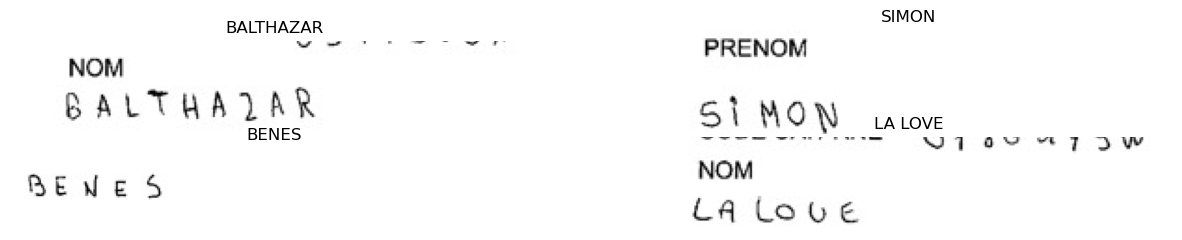

In [139]:
plt.figure(figsize=(15,10))

for i in range(4):
    ax = plt.subplot(4, 2, i+1)
    img_dir = './train_v2/train/' + train_name.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE) # Reaad image from directory
    plt.imshow(image, cmap = 'gray')
    plt.title(train_name.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

### Data Cleaning
**Check for null entries in the csv files.**

In [21]:
print("Null in the train dataset is: ", train_name['IDENTITY'].isnull().sum())
print("Null in the validation dataset is: ", val_name['IDENTITY'].isnull().sum())
print("Null in the test dataset is: ", test_name['IDENTITY'].isnull().sum())

Null in the train dataset is:  565
Null in the validation dataset is:  78
Null in the test dataset is:  70


**Get rid of all the null entries.**

In [22]:
train_name.dropna(axis=0, inplace=True)
val_name.dropna(axis=0, inplace=True)
test_name.dropna(axis=0, inplace=True)

**Some images that are unreadable. Some examples here.**

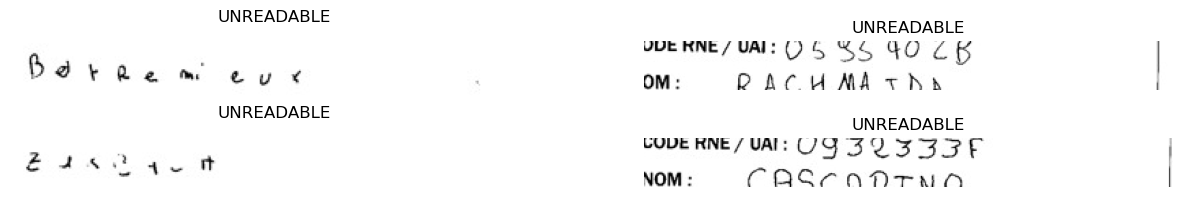

In [23]:
unreadable = train_name[train_name['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop = True)

plt.figure(figsize=(15,10))

for i in range(4):
    ax = plt.subplot(4, 2, i+1)
    img_dir = './train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

**Drop unreadable images in the csv dataset**

In [24]:
train_name = train_name[train_name['IDENTITY'] != 'UNREADABLE']
val_name = val_name[val_name['IDENTITY'] != 'UNREADABLE']
test_name = test_name[test_name['IDENTITY'] != 'UNREADABLE']

**Lowercase for uniformity in data**

In [25]:
train_name['IDENTITY'] = train_name['IDENTITY'].str.lower()
val_name['IDENTITY'] = val_name['IDENTITY'].str.lower()
test_name['IDENTITY'] = test_name['IDENTITY'].str.lower()

In [42]:
train_name.head(2)

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,balthazar
1,TRAIN_00002.jpg,simon


In [43]:
val_name.tail(2)

,FILENAME,IDENTITY
41368,VALIDATION_41369.jpg,hamelin
41369,VALIDATION_41370.jpg,lola


In [44]:
test_name.head(2)

,FILENAME,IDENTITY
0,TEST_0001.jpg,kevin
1,TEST_0002.jpg,clotaire


In [26]:
# Reset the index and the data cleaning is done.
train_name.reset_index(inplace = True, drop = True)
val_name.reset_index(inplace = True, drop = True)
test_name.reset_index(inplace = True, drop = True)

**Image Preprocessing & normalizing**

Preprocessing the dataset by resizing the images to a consistent size, normalizing the pixel values.
Reshape images to width 265 and height 64. If images are larger than this dimension, crop the image. if the image is smaller than this dimension, we will add white pixels padding and rotate to (x, y). And images are normalized to [0, 1].

**Splitted it into training test & validation sets.**

In [28]:
def image_processing(img):
    (h, w) = img.shape
    final_img = np.ones([64, 256])*255 # blank white image
    # crop if image dimension exceeds the said criteria
    if w > 256:
        img = img[:, :256]
    if h > 64:
        img = img[:64, :]
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

df_size = 10000

train_x = []
val_x = []
test_x = []

for i in range(df_size):
    img_dir = './train_v2/train/' + train_name.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = image_processing(image)
    image = image/255.  ## Normalization
    image = np.expand_dims(image, axis = 2)
    train_x.append(image)
    
for i in range(df_size):
    img_dir = './validation_v2/validation/' + val_name.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = image_processing(image)
    image = image/255. ## Normalization
    image = np.expand_dims(image, axis = 2)
    val_x.append(image)
    
for i in range(df_size):
    img_dir = './test_v2/test/' + test_name.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = image_processing(image)
    image = image/255. ## Normalization
    image = np.expand_dims(image, axis = 2)
    test_x.append(image)
   
train_x = np.array(train_x)
val_x = np.array(val_x)
test_x = np.array(test_x)

In [29]:
train_x.shape, val_x.shape, test_x.shape

((10000, 256, 64, 1), (10000, 256, 64, 1), (10000, 256, 64, 1))

In [30]:
train_y = []
val_y = []
test_y = []

def tokenize_df(values, df) -> List:
    max_length = max([len(label) for label in train_name['IDENTITY'].values])
    tokenizer = Tokenizer(num_words = max_length, char_level = True)
    tokenizer.fit_on_texts(values)
    list_y = []
    for i in range(val_size):
        label = df.loc[i, 'IDENTITY']
        label_sequence = tokenizer.texts_to_sequences([label])
        label = pad_sequences(label_sequence, maxlen = max_length, padding = 'post')[0]
        list_y.append(label)
    return list_y
        
train_y = tokenize_df(train_name['IDENTITY'].values, train_name)
val_y = tokenize_df(val_name['IDENTITY'].values, val_name)
test_y = tokenize_df(test_name['IDENTITY'].values, test_name)

train_y = np.array(train_y)
val_y = np.array(val_y)
test_y = np.array(test_y)

In [31]:
train_y.shape, val_y.shape, test_y.shape

((10000, 34), (10000, 34), (10000, 34))

**Building an FNN model, adding & tune the hyperparameters to optimize performance**

In [67]:
tf.keras.backend.clear_session()

# Create a sequential model
model = Sequential()

# Add the input layer
image_size = (256, 64)
model.add(Dense(1, activation='relu', input_shape=image_size + (1,)))
model.add(Flatten())

# Add hidden layers
model.add(Dense(256, activation='relu'))

# Add the output layer
model.add(Dense(34, activation='softmax'))

# Compile the model with ADAM optimizer and categorical crossentropy loss
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256, 64, 1)        2         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense_1 (Dense)             (None, 256)               4194560   
                                                                 
 dense_2 (Dense)             (None, 34)                8738      
                                                                 
Total params: 4,203,300
Trainable params: 4,203,300
Non-trainable params: 0
_________________________________________________________________


**Train the model using the training set**


In [68]:
history = model.fit(train_x, train_y, epochs=10, batch_size=32, validation_data=(val_x, val_y))

Epoch 1/10
313/313 [==============================] - 23s 73ms/step - loss: 160.5399 - accuracy: 0.2942 - val_loss: 154.2373 - val_accuracy: 0.3815
Epoch 2/10
313/313 [==============================] - 20s 63ms/step - loss: 147.8870 - accuracy: 0.3461 - val_loss: 143.3161 - val_accuracy: 0.3815
Epoch 3/10
313/313 [==============================] - 20s 65ms/step - loss: 138.4787 - accuracy: 0.3637 - val_loss: 135.2510 - val_accuracy: 0.3815
Epoch 4/10
313/313 [==============================] - 20s 65ms/step - loss: 131.4815 - accuracy: 0.3718 - val_loss: 129.2143 - val_accuracy: 0.3815
Epoch 5/10
313/313 [==============================] - 21s 66ms/step - loss: 126.2178 - accuracy: 0.3718 - val_loss: 124.6631 - val_accuracy: 0.3815
Epoch 6/10
313/313 [==============================] - 20s 64ms/step - loss: 122.2065 - accuracy: 0.3718 - val_loss: 121.1701 - val_accuracy: 0.3815
Epoch 7/10
313/313 [==============================] - 20s 65ms/step - loss: 119.0625 - accuracy: 0.3718 - val_lo

**Evaluate the model on the Test dataset**

In [69]:
# Evaluate the model on the test data.
test_loss, test_accuracy = model.evaluate(test_x, test_y)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

313/313 [==============================] - 2s 5ms/step - loss: 113.7884 - accuracy: 0.3814
Test loss: 113.78843688964844
Test accuracy: 0.3813999891281128


**Report the classification accuracy and other evaluation metrics**

In [65]:
# Assuming you have obtained predicted probabilities for the test data
predictions = model.predict(test_x)
predicted_classes = np.argmax(predictions, axis=1)

# Convert the target values to one-hot encoded format
test_y_one_hot = np.argmax(test_y, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_y_one_hot, predicted_classes)
print("Accuracy:", accuracy)

313/313 [==============================] - 2s 5ms/step
Accuracy: 0.3814


In [66]:
# Calculate precision, recall, and F1-score
precision = precision_score(test_y_one_hot, predicted_classes, average='macro')
recall = recall_score(test_y_one_hot, predicted_classes, average='macro')
f1 = f1_score(test_y_one_hot, predicted_classes, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.025426666666666667
Recall: 0.06666666666666667
F1-score: 0.03681289513054389


/Users/shindk/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
